Welcome!  If you are new to Google Colab/Jupyter notebooks, you might take a look at [this notebook](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) first.

**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](http://underactuated.csail.mit.edu/optimization.html).**

# Notebook Setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- import packages used throughout the notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast (even on Colab) because the machine will already have drake installed.

In [ ]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='560c2adace05eb20ebd78377582015d5b2d3859a', drake_version='0.27.0', drake_build='release')


# SDP relaxation of non-convex quadratic constraints

Consider the problem:

\begin{align*}
\min_x \quad & \| x - a \|^2 \\
\text{subject to} \quad & \| x - b \| \ge 1
\end{align*}

We can write this as

\begin{align*}
\min_{x,y} \quad & y - 2ax + a^2 \\
\text{subject to} \quad & y - 2bx + b^2 \ge 1 \\
& y \ge x^2
\end{align*}

where we write $y \ge x^2$ as the semidefinite constraint
$\begin{bmatrix} y & x \\ x & 1 \end{bmatrix}.$  I've plotted the feasible
region and the objective with an arrow.  As you know, for linear
objectives, the optimal solution will lie on the boundary only if the cost is
directly orthogonal to the objective; otherwise it will lie at a vertex.  So in
this case, the solution will only lie on the interior if $a = b;$ for every
other value, this relaxation will give the optimal solution.  (Try changing $a$ to see).

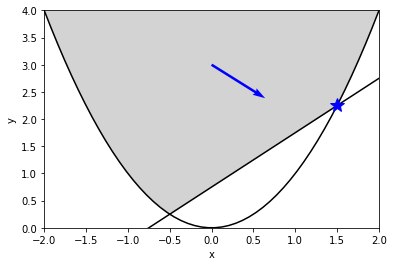

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
a = .8
b = .5
x = np.linspace(-2, 2)
plt.fill(x, np.maximum(x*x, 1 + 2*b*x - b*b), color='lightgray')
ax.plot(x, x*x, 'k')
ax.plot(x, 1 + 2*b*x - b*b, 'k')
qx = 0
qy = 3
scale=4
ax.quiver(qx, qy, 2*a, -1, scale=10, zorder=2, color='b')

ax.set_xlim(-2, 2)
ax.set_ylim(0, 4)
ax.set_xlabel('x')
ax.set_ylabel('y')

from pydrake.all import MathematicalProgram, Solve

prog = MathematicalProgram()
x = prog.NewContinuousVariables(1, 'x')[0]
y = prog.NewContinuousVariables(1, 'y')[0]

prog.AddPositiveSemidefiniteConstraint(np.array([[y, x],[x, 1]]))
prog.AddLinearConstraint(y - 2*b*x + b*b >= 1)
prog.AddLinearCost(y - 2*a*x + a*a)

result = Solve(prog)
ax.plot(result.GetSolution(x), result.GetSolution(y), 'b*', markersize=15);

# Global optimization with Sums-of-Squares (the "Six Hump Camel")

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pydrake.all import MathematicalProgram, Solve

from underactuated.jupyter import SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

prog = MathematicalProgram()
v = prog.NewIndeterminates(2, "x")
x = v[0]
y = v[1]

# This is the famous "six-hump camel back function".  It has six local
# minima, two of them being global minima.
p = 4 * x**2 + x * y - 4 * y**2 - 2.1 * x**4 + 4 * y**4 + x**6 / 3

# Find the minimum value by adding a sums of squares constraint, via
#   for all x, p(x) >= pmin
# which we write as
#   p(x) - pmin is sos.
pmin = prog.NewContinuousVariables(1, "pmin")[0]
prog.AddSosConstraint(p - pmin)

# Maximize pmin.
prog.AddCost(-pmin)

result = Solve(prog)
assert result.is_success()
print("Minimum value (lower bound): " + str(result.GetSolution(pmin)))

# Now, let's plot it.
fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(121, projection="3d")
ax1 = fig.add_subplot(122)
xs = np.linspace(-2.2, 2.2, 51)
ys = np.linspace(-1.2, 1.2, 51)
[X, Y] = np.meshgrid(xs, ys)
P = X.copy()
for i in range(len(xs)):
    for j in range(len(ys)):
        P[i, j] = p.Evaluate({x: X[i, j], y: Y[i, j]})
ax0.plot_surface(X, Y, P)
ax1.contour(X, Y, P, 100)

print("Minimum sampled value: " + str(np.min(P)))